In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

데이터 불러오기

In [2]:
data_path= "data"
signal_name = 'signal2'
normal_files = glob.glob(data_path+'/'+signal_name+'/normal/'+'*.csv')
anormal_drift_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/drift/'+'*.csv')
anormal_erratic_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/erratic/'+'*.csv')
anormal_hardover_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/hardover/'+'*.csv')
anormal_spike_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/spike/'+'*.csv')
anormal_stuck_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/stuck/'+'*.csv')

In [3]:
print(anormal_drift_files)

['data/signal2/normal+anormal/drift\\signal2_drift0.csv', 'data/signal2/normal+anormal/drift\\signal2_drift1.csv', 'data/signal2/normal+anormal/drift\\signal2_drift10.csv', 'data/signal2/normal+anormal/drift\\signal2_drift100.csv', 'data/signal2/normal+anormal/drift\\signal2_drift101.csv', 'data/signal2/normal+anormal/drift\\signal2_drift102.csv', 'data/signal2/normal+anormal/drift\\signal2_drift103.csv', 'data/signal2/normal+anormal/drift\\signal2_drift104.csv', 'data/signal2/normal+anormal/drift\\signal2_drift105.csv', 'data/signal2/normal+anormal/drift\\signal2_drift106.csv', 'data/signal2/normal+anormal/drift\\signal2_drift107.csv', 'data/signal2/normal+anormal/drift\\signal2_drift108.csv', 'data/signal2/normal+anormal/drift\\signal2_drift109.csv', 'data/signal2/normal+anormal/drift\\signal2_drift11.csv', 'data/signal2/normal+anormal/drift\\signal2_drift110.csv', 'data/signal2/normal+anormal/drift\\signal2_drift111.csv', 'data/signal2/normal+anormal/drift\\signal2_drift112.csv', 'd

In [4]:
def dataReader(path_names):
    data_n = pd.DataFrame() #판다스의 데이터프레임 형태로 프레임 생성
    for i in path_names:
        low_data = pd.read_csv(i)# 판다스 형태로 읽음, 한csv파일씩 읽기 떄문에 다음 라인에서 하나로 합침
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

In [5]:
normal_datas = dataReader(normal_files)
drift_datas = dataReader(anormal_drift_files)
erratic_datas = dataReader(anormal_erratic_files)
hardover_datas = dataReader(anormal_hardover_files)
spike_datas = dataReader(anormal_spike_files)
stuck_datas = dataReader(anormal_stuck_files)

In [6]:
print(drift_datas)

             value  error  error_size
0        54.130690    0.0         0.0
1        50.576253    0.0         0.0
2        52.093751    0.0         0.0
3        52.405754    0.0         0.0
4        52.602667    0.0         0.0
...            ...    ...         ...
4031995  50.794258    0.0         0.0
4031996  44.659721    0.0         0.0
4031997  49.849652    0.0         0.0
4031998  52.082076    0.0         0.0
4031999  48.506412    0.0         0.0

[4032000 rows x 3 columns]


data shape 변경

In [7]:
#LSTM, LSTM-AE
def X_to_XyLSTM_shape(X,ntime_in,ntime_out): #X변형할 시계열 데이터 n_time_in 만큼 하나의 input으로 봄, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_in -ntime_out + 1
    X_ntime = [0 for _ in range(nsample)]
    for i in range(nsample):
        X_ntime[i] = X[i:i+ntime_in]
    X_train = np.reshape(X_ntime,(nsample,ntime_in,1)) #2차원 배열을 3차원 배열으로
    #print('X',X_train.shape)
    y_nfuture = [0 for _ in range(nsample)]
    for i in range(nsample):
        y_nfuture[i] = X[i+ntime_in:i+ntime_in+ntime_out]
    y_train = np.array(y_nfuture)
    #print('y',y_train.shape)
    return X_train,y_train

In [8]:
n_time_in = 10 # 10개의 데이터 입력으로 받음
ntime_out = 1 # 다음 한개의 데이터 목표값

X_LSTM_train, y_LSTM_train = X_to_XyLSTM_shape(normal_datas['value'],n_time_in,ntime_out)

모델생성

In [9]:
from tensorflow.python.keras.layers import InputLayer, Dense, LSTM
from tensorflow.python.keras.models import Sequential

#LSTM 모델
LSTM_model = Sequential()

LSTM_model.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_model.add(Dense(ntime_out))

LSTM_model.compile(loss="mean_squared_error",optimizer='adam')

학습

In [10]:
LSTM_model.fit(X_LSTM_train,y_LSTM_train,epochs=1,batch_size=100,verbose=0)

추론

In [11]:
predict_data = stuck_datas['value'][:4000]

In [12]:
X_LSTM_test,y_LSTM_test = X_to_XyLSTM_shape(predict_data,n_time_in,ntime_out)
y_LSTM_predict = LSTM_model.predict(X_LSTM_test,verbose=0)
i = 0
print(np.array(X_LSTM_test[i+n_time_in]))

[[56.0951614 ]
 [54.3439581 ]
 [56.17286247]
 [59.88285268]
 [58.3488179 ]
 [59.99132579]
 [57.38363454]
 [63.08762926]
 [60.37821343]
 [60.32885183]]


In [13]:
print(np.array(X_LSTM_test[i+1]))

[[49.59940782]
 [51.99194166]
 [52.88113856]
 [50.15236094]
 [54.30767864]
 [53.02451236]
 [58.50671342]
 [54.9024981 ]
 [54.34441381]
 [56.0951614 ]]


In [14]:
print(np.array(y_LSTM_test[i]))

[56.0951614]


In [15]:
print(np.array(y_LSTM_predict[i]))

[56.944275]


In [16]:
def MSE(target,predict):
    return (1.0/2.0)*(target-predict)**2

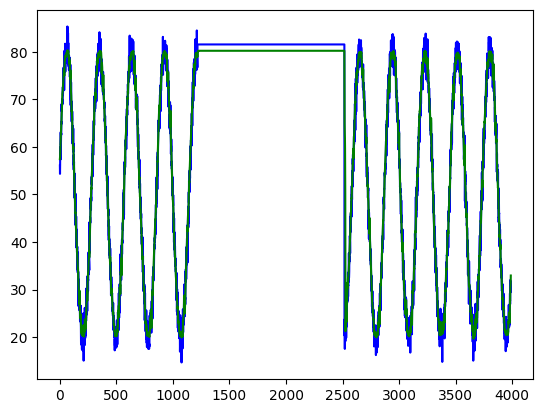

In [24]:
test_size = len(y_LSTM_predict)
plt.plot(y_LSTM_test[:test_size-ntime_out],c='blue')
plt.plot(y_LSTM_predict[ntime_out:test_size],c='green')
plt.plot(MSE(y_LSTM_test[:test_size-ntime_out],y_LSTM_predict[ntime_out:test_size]),c='orange') #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
plt.show()
plt.close()